# Lưu ý chung

**Ngôn ngữ**: Để hạn chế các rào cản về ngôn ngữ, bài giảng này sẽ được soạn bằng tiếng Việt, các thuật ngữ chuyên môn sẽ được giữ nguyên bằng tiếng Anh (có dịch tiếng Việt trong ngoặc đi kèm).

**Kiến thức tiên quyết**:
* Nhân ma trận
* Neural networks (mạng neuron nhân tạo) và feed-forward neural networks
* Tensor (i.e. ma trận với số chiều tùy ý)

**Thư viện sử dụng**: Keras (ngôn ngữ Python), NumPy và OpenCV (các bạn tham khảo cách cài đặt ở dưới đây)

# Lý thuyết

## Giới thiệu về CNN

Convolutional neural network (mạng tích chập), gọi tắt là CNN, là một khái niệm đã rất quen thuộc với ngành computer vision và deep learning.

## Cấu trúc mạng CNN

![CNN illustration](https://cdn-images-1.medium.com/max/1600/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

Một mạng CNN thông thường sẽ bao gồm các lớp sau:

* Convolutional layer (lớp tích chập)

* Pooling layer (lớp pooling)

* Fully-connected layer (một lớp neuron trong mạng feed-forward thông thường)

Ngoài các lớp phổ biến trên, một mạng CNN có thể có nhiều loại lớp khác nữa, ví dụ như lớp upsampling (thường được sử dụng trong bài toán semantic segmentation - với mỗi pixel, dự đoán xem pixel đó thuộc vật thể nào trong ảnh). 

**Lớp convolutional layer**:

![Convolutional layer illustration](https://cdn-images-1.medium.com/max/1600/1*7S266Kq-UCExS25iX_I_AQ.png)

Đây là linh hồn của mạng CNN, cái tên "convolutional neural networks" cũng xuất phát từ đây. Convolutional layer được phát kiến dựa trên cách bộ não tiếp nhận thông tin hình ảnh. Cụ thể, khi chúng ta nhìn vào một bức ảnh chứa một chiếc ô tô, chúng ta không nhìn cụ thể từng pixel, mà chúng ta sẽ nhìn các bộ phận của chiếc ô tô trước, ví dụ bánh xe, gương, mui xe, ... Từ các bộ phận đó, chúng ta suy rộng ra về hình dáng của chiếc xe và các đặc trưng khác tổng quát hơn của xe. Cuối cùng chúng ta nhận diện được trong ảnh có một chiếc xe.

Trước hết, để nhận diện trong xe có một chiếc gương, chúng ta cần nhìn vào một vùng các pixels cạnh nhau. Tạm gọi vùng đó là vùng $R$ gồm các pixels $p^{(1)}, p^{(2)}, ..., p^{(N)}$. Như các bạn đã biết, mỗi pixel $p^{(i)}$ sẽ bao gồm 3 giá trị $p^{(i)}_r, p^{(i)}_g, p^{(i)}_b$ tương ứng 3 kênh màu red - green - blue. Dựa vào khái niệm về hàm số đã được giảng ở các buổi học trước, chúng ta mô hình hóa chiếc gương bằng một hàm số của các pixels trong vùng $R$. Cụ thể như sau:

$\hspace{2.0cm} G = f(p^{(1)}_r, p^{(1)}_g, p^{(1)}_b, ..., p^{(N)}_r, p^{(N)}_g, p^{(N)}_b)$

$G$ ở đây là một scalar (VD một số thực, hoặc một vector) cho biết liệu trong vùng $R$ có chứa chiếc gương xe không, nếu có thì chiếc gương có những đặc điểm gì. $f$ là hàm số ánh xạ các pixels trong vùng $R$ tới $G$. Ở đây, $f$ chính là một hàm số có dạng như sau

$\hspace{2.0cm} f(\textbf{x}) = \sigma(b + \sum_i w_i x_i)$ 

$\sigma$ là một hàm phi tuyến và $b$ là bias (độ lệch). Như các bạn biết, hàm tuyến tính là một hàm số rất đơn giản nên không cho phép ta trích xuất các đặc trưng phức tạp. Để trích xuất được các đặc trưng phức tạp hơn, ta cần có một chút yếu tố "phi tuyến" để có thể mô hình hóa được nhiều họ hàm số hơn. Bộ tham số $(w_1, ..., w_n, b)$ phụ trách việc phát hiện gương xe trong vùng các pixels. Để tiết kiệm chi phí tính toán và lưu trữ, cũng như dựa trên quan sát rằng những chiếc gương xe có thể xuất hiện ở nhiều vị trí trong ảnh, bộ tham số này được áp dụng chung cho toàn bộ các vùng pixels trong ảnh.

Về lý thuyết, chúng ta sẽ có một ma trận $\textbf{W} \in \textbf{R}^{k \times k}$ (gọi là kernel) gồm các tham số $w$ và một số $b \in \textbf{R}$. Ta có thể coi $\textbf{W}$ là một ô cửa sổ vuông, sau đó ta di chuyển ô vuông này xung quanh ảnh theo một quy luật nào đó. Tại mỗi vị trí của ô vuông, tương ứng với một vùng $k \times k$ pixels $R$. Ta thực hiện phép toán "trích xuất gương xe" như trên. Cụ thể là

$\hspace{2.0cm} G = \sigma(b + \sum_{i, j} \textbf{W}_{i, j} R_{i, j})$

Sau khi di chuyển $\textbf{W}$ qua toàn bộ ảnh, chúng ta sẽ được một feature map (bản đồ đặc trưng) $\textbf{G}$. Trong mạng CNN thông thường, chúng ta sẽ sử dụng nhiều bộ tham số $\textbf{W}$ trên cùng một vùng ảnh, mỗi bộ tham số sẽ trích xuất một đặc trưng (VD gương xe, bánh xe, ...) và cho ra một feature map riêng. Các feature map sau đó sẽ được xếp chồng lên nhau và được sử dụng để trích xuất các đặc trưng cao cấp hơn theo cách tương tự.

Một convolutional layer sẽ di chuyển $\textbf{W}$ xung quanh ảnh và thực hiện phép toán trích xuất đặc trưng được. Sau nhiều lớp convolutional layers, mạng CNN của ta sẽ học hỏi được những thông tin cao cấp như trong ảnh có xe ô tô không, nếu có thì ở đâu, ...

**Lớp pooling**:

![Pooling layer illustration](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

Có thể thấy, một ảnh màu (ảnh đầu vào) của một mạng CNN sẽ có tổng cộng $h \times w \times 3$ thành phần số thực. Như vậy, chỉ cần một ảnh cỡ $100 \times 100$ là ta đã phải lưu trữ $3 \times 10^4$ số thực. Đi qua các layers khác nhau của mạng CNN, mỗi layer lại cho ra một tensor có kích cỡ $h \times w \times c$ với $h w c$ phần tử. Như vậy có thể thấy việc chạy một mạng CNN rất tốn kém về cả thời gian và bộ nhớ. 

Để giải quyết vấn đề này, người ta giới thiệu lớp pooling. Bản chất của lớp pooling là đưa vào một tensor có kích cỡ $h \times w \times c$, lớp pooling sẽ downsample ảnh xuống còn cỡ $h_1 \times w_1 \times c$ với $h_1, w_2$ thường là $h/2$ và $w/2$. Để thực hiện việc downsample, giả sử ta muốn downsample một ảnh cỡ $h \times w$ xuống còn $h/2 \times w/2$, ta sẽ bắt đầu ở pixel $(0, 0)$, sau đó giữ lại trung bình hoặc max value của một ô vuông $2 \times 2$ bao chứa pixel $(0, 0)$ đó và chuyển sang ô vuông $2 \times 2$ tiếp theo (theo chiều ngang hoặc dọc).

Pooling giúp giảm độ phức tạp tính toán và bộ nhớ xuống đáng kể, cho phép chúng ta áp dụng rộng rãi hơn cấu trúc mạng CNN. Tuy nhiên một điểm yếu chết người của pooling (ở đây là max pooling) là sự mất mát thông tin về vị trí của feature. Cụ thể, trong một ô vuông $2 \times 2$, chúng ta sẽ trả về pixel lớn nhất trong ô, không quan tâm pixel đó ở đâu, như vậy là chúng ta đã "mất dấu" vị trí của pixel đó nếu tiếp tục đi lên các lớp cao hơn. Để cải thiện vấn đề này, người ta đã đưa ra một số phương pháp như skip-connection (ResNet), CapsuleNet, ... 

Phép toán pooling đã được chứng minh, dựa trên thực tế, rằng phép toán có thể hoạt động rất hiệu quả.

**Lớp fully-connected (FC)**: 

![FC layer illustration](https://www.oreilly.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0401.png)

Trong các bài toán yêu cầu đầu ra của mạng CNN là một vector có size cố định, fully-connected layer sẽ là một lựa chọn không tồi. Ví dụ như trong bài toán phân loại ảnh, đầu ra của mạng CNN phải là một probability vector $p$ với $p_i$ là xác suất (dự đoán) rằng ảnh thuộc class $i$. Tuy nhiên, việc áp dụng lớp FC có thể dẫn tới hệ quả rằng ảnh đầu vào của mạng CNN cũng phải có size cố định. Do bản chất của convolutional layer là di chuyển ô vuông quanh ảnh nên việc áp dụng convolutional layer không đưa ra ràng buộc rằng ảnh input phải có size cố định. Để cải thiện vấn đề này, người ta đưa ra các layer như RoI pooling để giúp đầu ra của mạng CNN với FC layer không phụ thuộc vào kích thước ảnh đầu vào.

# Thực hành

Chúng ta sẽ làm quen với CNN qua một ví dụ nhỏ - phân loại chữ số viết tay với bộ dữ liệu MNIST nổi tiếng.

**Cài đặt các thư viện**

In [1]:
!pip install keras
!pip install matplotlib

**Tải dữ liệu**

In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt

batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_x, img_y = 28, 28

# load the MNIST data set, which already splits into train and test sets for us
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the 
# categorical_crossentropy loss below
# Huy onehot vector???
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


**Xây dựng mô hình**

In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

W0704 01:02:28.371083 140526839510912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 01:02:28.417824 140526839510912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 01:02:28.425130 140526839510912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 01:02:28.472535 140526839510912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0704 01:02:28.552007 140526839510912 deprecation_wrapp

**Huấn luyện và đánh giá mô hình**

W0704 01:02:31.944810 140526839510912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0704 01:02:32.019496 140526839510912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 72s 1ms/step - loss: 0.1532 - acc: 0.9536 - val_loss: 0.0428 - val_acc: 0.9860
Epoch 2/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0433 - acc: 0.9867 - val_loss: 0.0269 - val_acc: 0.9921
Epoch 3/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0277 - acc: 0.9908 - val_loss: 0.0313 - val_acc: 0.9891
Epoch 4/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0207 - acc: 0.9933 - val_loss: 0.0288 - val_acc: 0.9905
Epoch 5/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0166 - acc: 0.9942 - val_loss: 0.0314 - val_acc: 0.9908
Epoch 6/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0122 - acc: 0.9962 - val_loss: 0.0322 - val_acc: 0.9903
Epoch 7/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0107 - acc: 0.9968 - val_loss: 0.0301 - val_acc

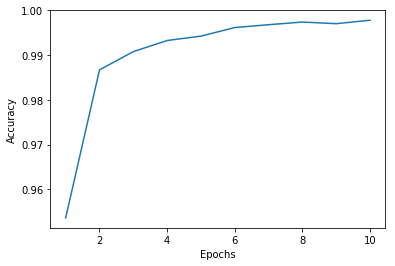

In [4]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 11), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [27]:
import numpy as np
pred_label = model.predict(x_test)
print(pred_label.shape)
pred_label = np.argmax(pred_label,axis = 1)
print(pred_label)
print(np.argmax(y_test,axis = 1))

(10000, 10)
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


In [50]:
import matplotlib.pyplot as plt
from display_network import *
N = 30
X = np.zeros((N*10,28,28,1))
for k in range(10):
  Xk = x_test[pred_label==k]
  X[N*k:N*(k+1)] = Xk[:N,:]
X= X.reshape(N*10,28*28)
print(X.shape)

(300, 784)


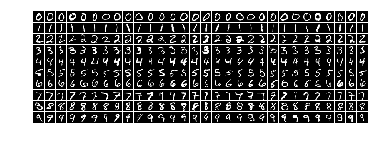

(10000, 28, 28, 1)
(10000,)
(30, 784)


In [51]:
plt.axis('off')
A = display_network(X.T, 10, N)
f2 = plt.imshow(A, interpolation='nearest' )
plt.gray()

plt.show()  
print(x_test.shape)
print(pred_label.shape)
print(X[N*k:N*(k+1)].shape)

# Tham khảo thêm
* [Blog machine learning  cơ bản](https://machinelearningcoban.com/2018/10/03/conv2d)
* [Khóa học CS231 của ĐH Stanford](http://cs231n.stanford.edu/)
* [Blog machine learning is fun](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721)
* [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)
* [Deep learning book](https://www.deeplearningbook.org/contents/convnets.html)